In [29]:
from settings import *

##### Set global constants for this experiment

In [30]:
delta_t = 0.1
N = 1
L = 100
depth=20
distance=0.9


##### Load observables

In [31]:
Os = all_observables(m=m)
jump_oper_decay = default_jump_operators(m=m, gammas=gammas)
jump_oper_no_decay = no_decay_jump_operators()

##### Make training data

In [32]:
rho0s = random_rho0s(m=m, L=L)
rhoss, ts = solve_lindblad_rho0s(rho0s=rho0s, delta_t=delta_t, N=N, s=system, jump_opers=jump_oper_decay)
training_data = mk_training_data(rhoss=rhoss, Os=Os)

random_rho0s: setting seed=30090


##### Create a qubit layout and a parametrized circuit on those qubits

In [33]:
qubits = TriangularLayoutA(m=m, distance=distance)
circuit = HEA_fac(qubits, depth=depth)

<Axes: title={'center': 'Qubit layout'}>

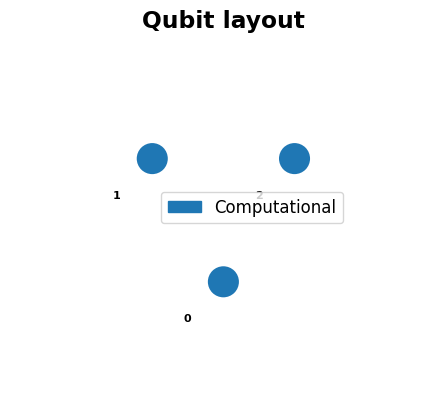

In [34]:
qubits.show_layout()

In [35]:
# optionally load already optimized theta

theta_opt = np.load("ham_theta_opt.npy")

##### Optimize the parameters

In [36]:
theta_opt, errors, thetas = optimize(
    circuit=circuit, 
    training_data=training_data, 
    n_grad=10, 
    max_count=1000,
    # theta_init=theta_opt
)

# optionally, save the results of the optimization process

theta_opt = np.save("ham_theta_opt.npy", theta_opt)
thetas = np.save("ham_thetas.npy", thetas)
errors = np.save("ham_errors.npy", errors)

optimizer (optimization indices): setting seed=93554


C:\Users\Admin\Desktop\BFP\quantum-channel-approximation\q_channel_approx\optimizer.py:82: ComplexWarning: Casting complex values to real discards the imaginary part
  errors[i] = error


small sigma
Zero gradient hit after 421 iterations


In [37]:
theta_opt = np.load("ham_theta_opt.npy")
thetas = np.load("ham_thetas.npy")
errors = np.load("ham_errors.npy")

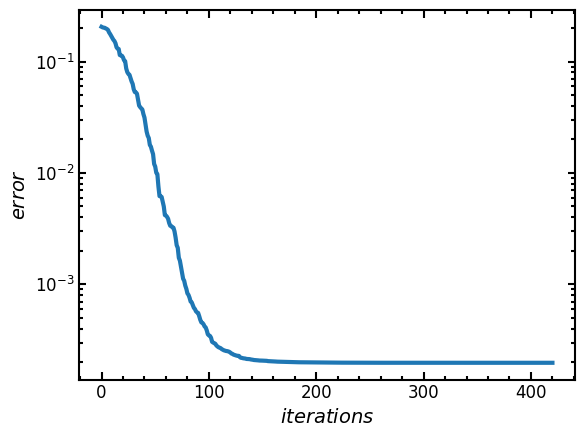

In [38]:
plt.semilogy(np.arange(len(errors)), errors)
plt.xlabel("$iterations$")
plt.ylabel("$error$")
plt.savefig("training-error-q3.pdf", bbox_inches="tight")

##### Plot approximated solution compared to reference solution

In [39]:
n_time_steps = 50

rho0 = rho_rand_haar(m=m)

Os_comp = [O.full() for O in create_observables_comp_basis(m=m)]

rho_rand_haar: seed=53359


In [40]:
# calculate reference solution

rhos_ref, ts = solve_lindblad_rho0(rho0, 
                                delta_t=delta_t, 
                                N=n_time_steps, 
                                s=system, 
                                jump_opers=jump_oper_decay,
                                )
Ess_ref = measure_rhos([r.full() for r in rhos_ref], Os_comp)

rhos_ref_no_decay, ts = solve_lindblad_rho0(
    rho0,
    delta_t=delta_t,
    N=n_time_steps,
    s=system,
    jump_opers=jump_oper_no_decay,
)
Ess_ref_no_decay = measure_rhos([r.full() for r in rhos_ref_no_decay], Os_comp)

# calculate approximated solution

evolver = evolver_fac(circuit, N=n_time_steps)(theta_opt)
rhos_approx = evolver(rho=rho0.full())
Ess_approx = measure_rhos(rhos_approx, Os_comp)

c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


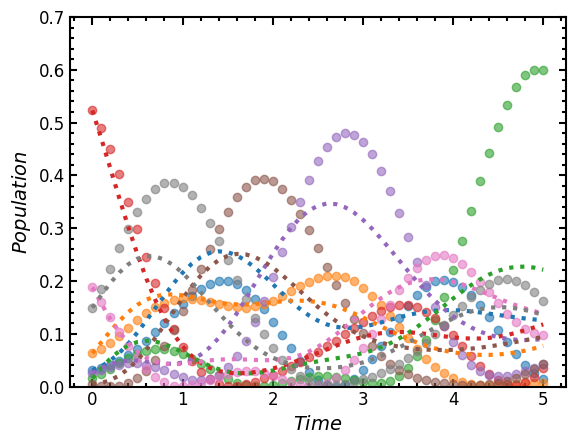

In [43]:
plot_approx(ts, Ess_approx)
plot_ref(ts, Ess_ref)

# some formatting to make plot look nice
plt.ylabel("$Population$")
plt.xlabel("$Time$")
plt.ylim(0, 0.7)
# lgd = plt.gca().legend(handles=legend_comp(m), loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig("q3-ham-decay.pdf", bbox_inches="tight")

c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


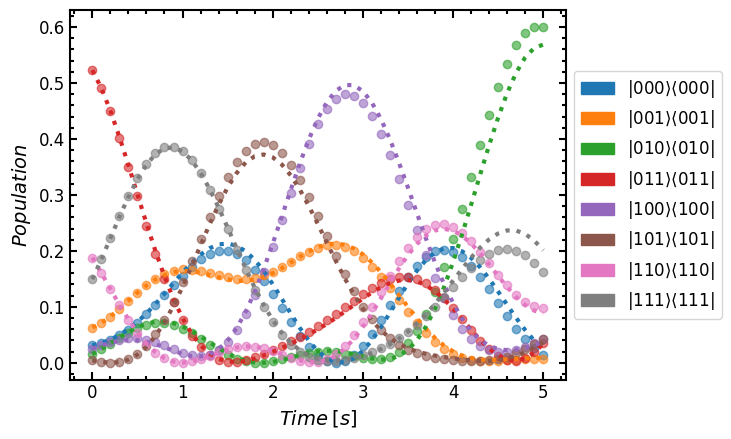

In [42]:
plot_approx(ts, Ess_approx)
plot_ref(ts, Ess_ref_no_decay)


# some formatting to make plot look nice
plt.ylabel("$Population$")
plt.xlabel("$Time \: [s]$")
# plt.ylim(0, 0.7)
plt.gca().legend(handles=legend_comp(m), loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig("q3-ham-no-decay.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")